# KL2 Analysis

In [64]:
%load_ext autoreload
%autoreload 2

## 3 Analysis

In [1]:
# choose outcome, either at discharge or discharge - admission
USE_AS_OUTCOME = ['dc', 'delta'][0]
EXCLUDE_THE_OTHER_MEASURE_ADM = True

# total # of features and a list of all feature names

import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate
import json

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_2_5.csv', low_memory=False, index_col='id')

# load splits
with open('./data/Cleaned files/data_splits.json', 'r') as f:
    split_dict = json.load(f)

print("# of train samples:", len(split_dict["train"]))
print("# of eval samples:", len(split_dict["eval"]))
print("# of test samples:", len(split_dict["test"]))

print("# of valid selfcare train samples:", df.loc[split_dict["train"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare eval samples:", df.loc[split_dict["eval"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare test samples:", df.loc[split_dict["test"]]['selfcare_measure_delta'].notna().sum())

print("# of valid mobility train samples:", df.loc[split_dict["train"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility eval samples:", df.loc[split_dict["eval"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility test samples:", df.loc[split_dict["test"]]['mobility_measure_delta'].notna().sum())


feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))

nan_counts = df.isna().sum(axis=0).to_dict()


def tabulate_df(df):
    feature_names = [*df.head()]
    feature_dtypes = df.dtypes
    nan_counts = df.isna().sum(axis=0).to_dict()
    return tabulate([(index, name, feature_dtypes[name], nan_counts[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype", "# of NaNs"], tablefmt="grid")

print(tabulate_df(df))

# load interested predictor and outcome name list
with open('./data/Cleaned files/selected_features.json', 'r') as f:
    selected_feature_dict = json.load(f)
therapy_predictors = selected_feature_dict['therapy_predictors']

predictors = [name for name in df.columns if name not in ['id', 'selfcare_measure_delta', 'mobility_measure_delta', 'selfcare_measure_dc', 'mobility_measure_dc']]


# of train samples: 28625
# of eval samples: 7156
# of test samples: 7157
# of valid selfcare train samples: 28625
# of valid selfcare eval samples: 7156
# of valid selfcare test samples: 7157
# of valid mobility train samples: 28625
# of valid mobility eval samples: 7156
# of valid mobility test samples: 7157
total # of features: 61
+---------+------------------------------------------------+---------+-------------+
|   Index | Name                                           | Dtype   |   # of NaNs |
+=========+================================================+=========+=============+
|       0 | ptindweek1                                     | float64 |           0 |
+---------+------------------------------------------------+---------+-------------+
|       1 | otindweek1                                     | float64 |           0 |
+---------+------------------------------------------------+---------+-------------+
|       2 | slpindweek1                                    | float64 

### 3.1 Selfcare

In [19]:
# drop invalid samples & split dataset

selfcare_df = df.dropna(subset=["selfcare_measure_delta"]).copy()

selfcare_split_dict = {} # since some rows are dropped, we need to filter the split dict
for k in split_dict.keys():
    selfcare_split_dict[k] = [idx for idx in split_dict[k] if idx in selfcare_df.index]

selfcare_train_df = selfcare_df.loc[selfcare_split_dict["train"]]
selfcare_eval_df = selfcare_df.loc[selfcare_split_dict["eval"]]
selfcare_test_df = selfcare_df.loc[selfcare_split_dict["test"]]

if EXCLUDE_THE_OTHER_MEASURE_ADM:
    selfcare_predictors = predictors.copy()
    selfcare_predictors.remove('mobility_measure_adm')
else:
    selfcare_predictors = predictors

X_train = selfcare_train_df[selfcare_predictors]
y_train = selfcare_train_df['selfcare_measure_' + USE_AS_OUTCOME]

X_eval = selfcare_eval_df[selfcare_predictors]
y_eval = selfcare_eval_df['selfcare_measure_' + USE_AS_OUTCOME]

X_test = selfcare_test_df[selfcare_predictors]
y_test = selfcare_test_df['selfcare_measure_' + USE_AS_OUTCOME]

print(min(y_test))

19.65


#### 3.1.1 Linear Regression

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regressor
linear_regressor = LinearRegression()

# Fit the model on the train set
linear_regressor.fit(X_train, y_train)

# Make predictions on all sets
y_train_pred = linear_regressor.predict(X_train)
y_eval_pred = linear_regressor.predict(X_eval)
y_test_pred = linear_regressor.predict(X_test)

# Train set performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Eval set performance
eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

# Test set performance
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")

print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 345.03192292015507
R²: 0.26396934687901585
----------eval set results----------
MSE: 337.66511389063197
R²: 0.27725096641358604
----------test set results----------
MSE: 340.19423933094663
R²: 0.26431273769540053


In [265]:
# linear regression analysis summary

import statsmodels.api as sm

X_train_with_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_with_constant)
results = model.fit()

print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     selfcare_measure_delta   R-squared:                       0.243
Model:                                OLS   Adj. R-squared:                  0.242
Method:                     Least Squares   F-statistic:                     195.0
Date:                    Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                            04:29:30   Log-Likelihood:            -1.2425e+05
No. Observations:                   28625   AIC:                         2.486e+05
Df Residuals:                       28577   BIC:                         2.490e+05
Df Model:                              47                                         
Covariance Type:                nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

#### 3.1.2 Random Forest

In [20]:
# RF

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=20, max_features='sqrt')

# fit the model on the train set
rf_regressor.fit(X_train, y_train)

# make predictions on all sets
y_train_pred = rf_regressor.predict(X_train)
y_eval_pred = rf_regressor.predict(X_eval)
y_test_pred = rf_regressor.predict(X_test)

# train set performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# eval set performance
eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

# test set performance
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")

print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 91.5991893735957
R²: 0.8495066202795338
----------eval set results----------
MSE: 308.3964722149607
R²: 0.4971958000288471
----------test set results----------
MSE: 313.09633776924755
R²: 0.48205568783175823


In [37]:
# RF with CV grid search

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the model
rf_regressor = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-validation R² Score:", best_score)

# Optionally refit the model with the best parameters
rf_best = grid_search.best_estimator_
# Proceed with refitting and evaluation as in your original code

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END ...max_depth=5, max_features=auto, n_estimators=200; total time=   0.0s[CV] END ...max_depth=5, max_features=auto, n_estimators=100; total time=   0.0s

[CV] END ....max_depth=5, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=5, max_features=auto, n_estimators=100; total time=   0.0s[CV] END ...max_depth=5, max_features=auto, n_estimators=100; total time=   0.0s[CV] END ...max_depth=5, max_features=auto, n_estimators=100; total time=   0.0s


[CV] END ...max_depth=5, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END ....max_depth=5, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END ....max_depth=5, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END ....max_depth=5, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=5, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ....max_depth=5, max_features=auto, n_

/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ..max_depth=30, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=  15.2s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=  15.9s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=  16.2s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=  16.0s
[CV] END ...max_depth=30, max_features=sqrt, n_estimators=50; total time=   2.5s
[CV] END ...max_depth=30, max_features=sqrt, n_estimators=50; total time=   2.5s
[CV] END ..max_depth=20, max_features=log2, n_estimators=200; total time=   9.7s
[CV] END ..max_depth=20, max_features=log2, n_estimators=200; total time=   9.2s
[CV] END ...max_depth=30, max_features=sqrt, n_estimators=50; total time=   3.1s
[CV] END ...max_depth=30, max_features=sqrt, n_estimators=50; total time=   3.0s
[CV] END ...max_depth=30, max_features=sqrt, n_estimators=50; total time=   3.1s
[CV] END ..max_depth=20, max

/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
52 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/sklearn/base.py", line 666

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}
Best Cross-validation R² Score: 0.37382214719485296


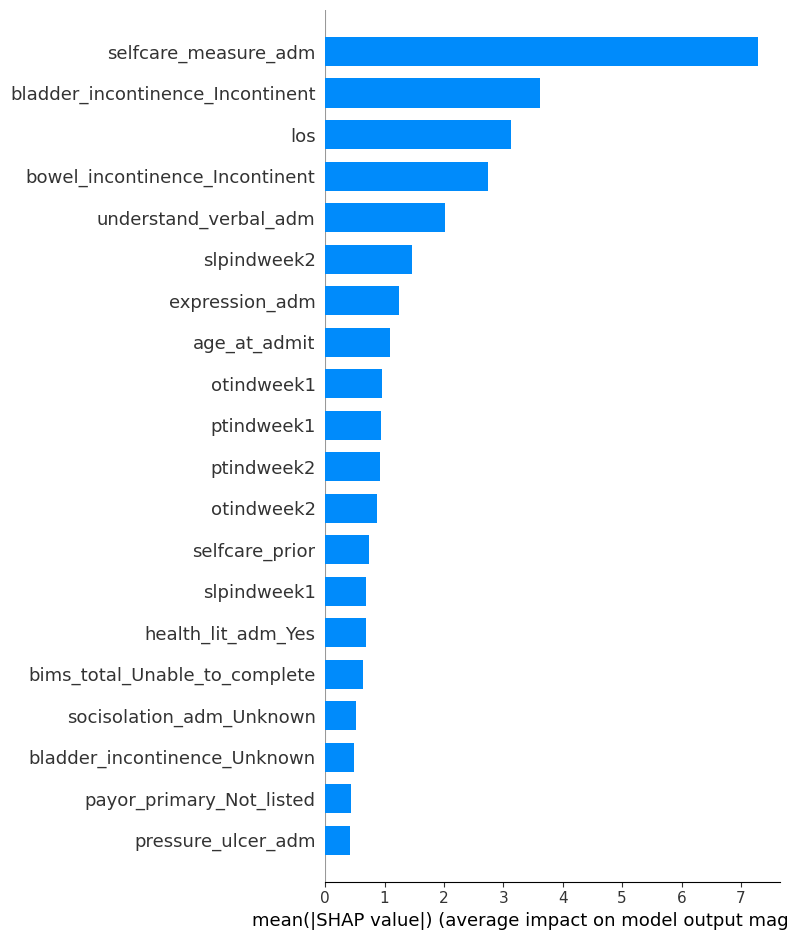

In [21]:
# shapley value test

import shap

explainer = shap.TreeExplainer(rf_regressor)

shap_values_train = explainer.shap_values(X_train, approximate=True) # turn off approximate for precise shap values, but way slower convergence
# shap_values_eval = explainer.shap_values(X_eval)
# shap_values_test = explainer.shap_values(X_test)

shap.summary_plot(shap_values_train, X_train, plot_type="bar")

{'ptindweek1': {'mean': 334.8618938935209, 'std': 98.03107181439556}, 'otindweek1': {'mean': 343.7301457916065, 'std': 93.48791534753497}, 'slpindweek1': {'mean': 206.4069821603242, 'std': 97.2304213018218}, 'ptindweek2': {'mean': 267.2649168568634, 'std': 153.44182705059745}, 'otindweek2': {'mean': 267.13186454888444, 'std': 150.43404230728342}, 'slpindweek2': {'mean': 161.12133774279192, 'std': 125.04271993579322}, 'expression_adm': {'mean': 3.1967255112021986, 'std': 0.9094768485944136}, 'understand_verbal_adm': {'mean': 3.3560249662303785, 'std': 0.8025979421361473}, 'selfcare_prior': {'mean': 2.879104755694257, 'std': 0.3439471858392802}, 'mobility_prior': {'mean': 2.925264334622013, 'std': 0.2868577702334126}, 'selfcare_measure_adm': {'mean': 40.33641785830732, 'std': 7.7260314602189775}, 'mobility_measure_adm': {'mean': 24.16327635194932, 'std': 9.008546930947631}, 'age_at_admit': {'mean': 68.7322418370674, 'std': 13.454395748007565}, 'los': {'mean': 16.196539196050118, 'std': 9

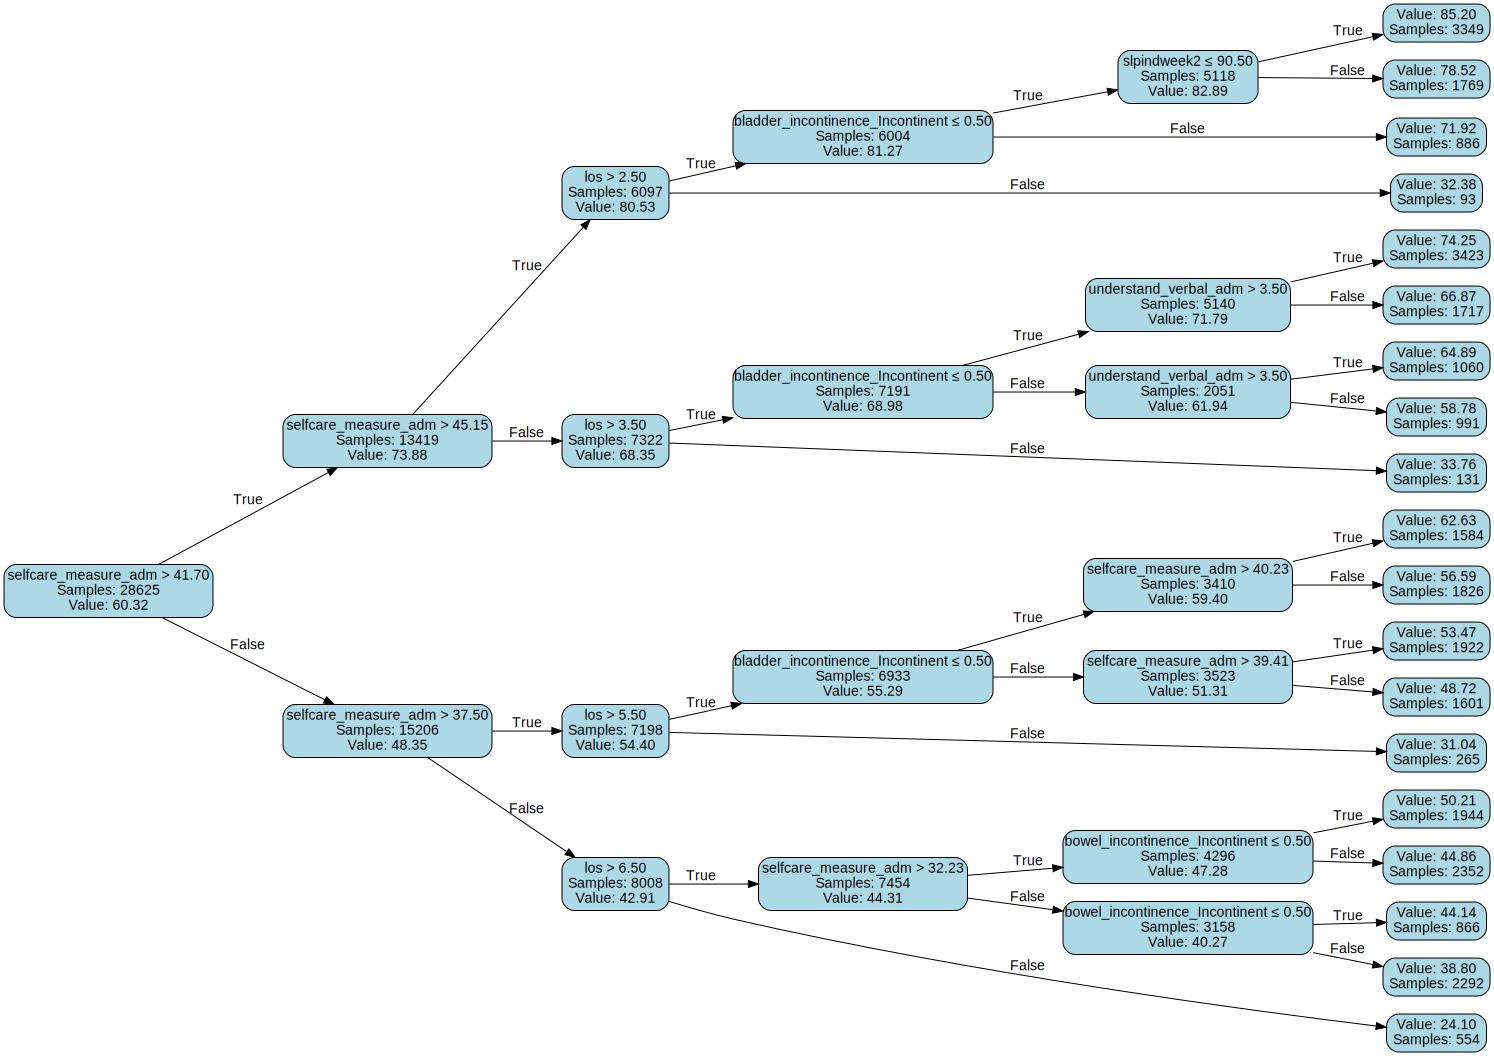

In [22]:
import graphviz
from sklearn.tree import _tree

with open('./data/Cleaned files/standardization_params.json', 'r') as f:
    scaling_params = json.load(f)
print(scaling_params)

def custom_export_graphviz(dtree, feature_names, scaling_params, precision=2, rotate=True, filled=True):
    """
    Final solution: Forces all leaves to the same rank (rightmost column).
    """
    tree_ = dtree.tree_
    total_samples = tree_.n_node_samples[0]
    actual_max_depth = dtree.get_depth()
    threshold_samples = total_samples / (2 ** actual_max_depth)
    
    dot = graphviz.Digraph()
    dot.attr('node', shape='box', style='rounded,filled', fontname='helvetica')
    dot.attr('edge', fontname='helvetica')
    if rotate:
        dot.attr('graph', rankdir='LR')  # Horizontal layout

    leaf_nodes = set()  # Track leaf node IDs

    def get_node_info(node_id):
        if tree_.feature[node_id] == _tree.TREE_UNDEFINED:
            return {
                'is_leaf': True,
                'value': tree_.value[node_id][0][0],
                'samples': tree_.n_node_samples[node_id]
            }
        else:  # Split node
            feature_name = feature_names[tree_.feature[node_id]]
            if feature_name in scaling_params.keys():
                threshold = tree_.threshold[node_id]*scaling_params[feature_name]['std'] + scaling_params[feature_name]['mean']
            else:
                threshold = tree_.threshold[node_id]
            return {
                'is_leaf': False,
                'feature': feature_name,
                'threshold': threshold,
                'samples': tree_.n_node_samples[node_id],
                'value': tree_.value[node_id][0][0],
                'left_child': tree_.children_left[node_id],
                'right_child': tree_.children_right[node_id]
            }

    def add_node(node_id, parent=None, edge_label=None, current_depth=0):
        info = get_node_info(node_id)
        node_name = str(node_id)
        
        # Early stopping if sample size is below threshold
        if not info['is_leaf'] and info['samples'] < threshold_samples:
            info['is_leaf'] = True

        if info['is_leaf']:
            label = f"Value: {info['value']:.{precision}f}\nSamples: {info['samples']}"
            leaf_nodes.add(node_name)  # Track leaf node
        else:
            # Determine true/false branches based on mean values
            left_val = get_node_info(info['left_child'])['value']
            right_val = get_node_info(info['right_child'])['value']
            
            # Flip condition to ensure True branch has higher value
            if left_val < right_val:
                condition = f"{info['feature']} > {info['threshold']:.{precision}f}"
                true_child = info['right_child']
                false_child = info['left_child']
            else:
                condition = f"{info['feature']} ≤ {info['threshold']:.{precision}f}"
                true_child = info['left_child']
                false_child = info['right_child']
            
            label = f"{condition}\nSamples: {info['samples']}\nValue: {info['value']:.{precision}f}"

            # Assign true_child and false_child to info for recursion
            info['true_child'] = true_child
            info['false_child'] = false_child

        # Add node to graph
        dot.node(node_name, label=label, fillcolor='lightblue' if filled else None)
        
        if parent is not None:
            dot.edge(parent, node_name, label=edge_label)
        
        # Recurse if not leaf
        if not info['is_leaf']:
            add_node(info['true_child'], node_name, 'True', current_depth + 1)
            add_node(info['false_child'], node_name, 'False', current_depth + 1)

    add_node(0, current_depth=0)

    # Force all leaves to the same rank
    with dot.subgraph() as s:
        s.attr(rank='same')  # Align all nodes in this subgraph to the same rank
        for leaf in leaf_nodes:
            s.node(leaf)

    return dot

# regress a summary tree and visualize

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# initialize the decision tree regressor
tree_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)  # you can adjust max_depth

# train a single regression tree to previous model's output
tree_regressor.fit(X_train, y_train_pred)

# test model
y_test_pred_pred = tree_regressor.predict(X_test)
print(f"min y_test = {min(y_test)}")
test_pred_mse = mean_squared_error(y_test_pred, y_test_pred_pred) # with previous model's output
test_pred_r2 = r2_score(y_test_pred, y_test_pred_pred)
test_mse = mean_squared_error(y_test, y_test_pred_pred) # with GT
test_r2 = r2_score(y_test, y_test_pred_pred)
print(f'MSE (w.r. previous model): {test_pred_mse}')
print(f"R² (w.r. previous model): {test_pred_r2}")
print(f'MSE (w.r. ground truth): {test_mse}')
print(f"R² (w.r. ground truth): {test_r2}")

# Generate visualization
dot = custom_export_graphviz(
    tree_regressor, 
    feature_names=selfcare_predictors,
    scaling_params=scaling_params,
    precision=2,
    rotate=True,
    filled=True
)

# Render and display
dot.render(filename='selfcare_tree', format='png', cleanup=True)
display(dot)  # For Jupyter notebooks

#### 3.1.3 XGBoost

In [20]:
# xgboost

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb_regressor = XGBRegressor(n_estimators=100, max_depth=3, random_state=42)

xgb_regressor.fit(X_train, y_train)

y_train_pred = xgb_regressor.predict(X_train)
y_eval_pred = xgb_regressor.predict(X_eval)
y_test_pred = xgb_regressor.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")


print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 269.9377897772553
R²: 0.40762372609464637
----------eval set results----------
MSE: 287.19507266714203
R²: 0.3662711817256159
----------test set results----------
MSE: 288.19284111144316
R²: 0.3582726233795176


In [269]:
from tabulate import tabulate

booster = xgb_regressor.get_booster()
importance_dict = booster.get_score(importance_type='gain')

importance_list = [(feature, score) for feature, score in importance_dict.items()]

importance_list = sorted(importance_list, key=lambda x: x[1], reverse=True)

print(tabulate(importance_list, headers=["Feature", "Gain"], tablefmt="pretty"))

+------------------------------------------------+--------------------+
|                    Feature                     |        Gain        |
+------------------------------------------------+--------------------+
|              mobility_measure_adm              |   9612.55859375    |
|              bladder_incontinence              |   8522.181640625   |
|                      los                       |  7966.0810546875   |
|             understand_verbal_adm              |    7278.1328125    |
|                 selfcare_prior                 |  5655.69384765625  |
|                 mobility_prior                 |  4459.1748046875   |
|              selfcare_measure_adm              | 3786.983642578125  |
|                   bims_total                   |  3397.39404296875  |
|               bowel_incontinence               | 3242.993896484375  |
|               pressure_ulcer_adm               |  2298.74853515625  |
|                 health_lit_adm                 | 2183.19604492

#### 3.1.4 Lasso

In [41]:
# lasso with manually tuned hyperparam alpha
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

lasso_regressor = Lasso(alpha=0.03, max_iter=10000, random_state=42)

lasso_regressor.fit(X_train, y_train)

y_train_pred = lasso_regressor.predict(X_train)
y_eval_pred = lasso_regressor.predict(X_eval)
y_test_pred = lasso_regressor.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

# model summary
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_regressor.coef_
})

# filter out features with zero coefficients
non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

print("\n---------- Model Summary: Non-zero Coefficients ----------")
print(tabulate(non_zero_coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True), headers='keys'))


---------- Train Set Results ----------
MSE: 345.3178
R²: 0.2422
---------- Eval Set Results ----------
MSE: 337.8222
R²: 0.2546
---------- Test Set Results ----------
MSE: 340.1314
R²: 0.2426

---------- Model Summary: Non-zero Coefficients ----------
    Feature                           Coefficient
--  ------------------------------  -------------
 0  mobility_measure_adm                7.05046
 1  ptindweek1                          2.26973
 2  otindweek1                          1.81161
 3  bims_total                          1.52195
 4  marital_status_Unmarried            1.1404
 5  selfcare_prior                      1.13944
 6  understand_verbal_adm               1.0571
 7  payor_primary_Medicare_FFS          0.992287
 8  race_White                          0.872495
 9  payor_primary_Not_listed            0.871874
10  pain_activities_adm                 0.730622
11  slpindweek1                         0.626042
12  mobility_prior                      0.389007
13  los            

In [45]:
# lasso with cross validation for tuning alpha
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

alpha_range = [0.001, 0.05, 0.03, 0.01, 0.5, 0.1, 0.5, 1, 5, 10, 50, 100]

lasso_cv = LassoCV(alphas=alpha_range, cv=5, max_iter=10000, random_state=42)

lasso_cv.fit(X_train, y_train)

best_alpha = lasso_cv.alpha_
print(f"Best alpha found: {best_alpha}")

y_train_pred = lasso_cv.predict(X_train)
y_eval_pred = lasso_cv.predict(X_eval)
y_test_pred = lasso_cv.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_cv.coef_
})

non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

print("\n---------- Model Summary: Non-zero Coefficients ----------")
print(non_zero_coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True))


Best alpha found: 0.03
---------- Train Set Results ----------
MSE: 345.3178
R²: 0.2422
---------- Eval Set Results ----------
MSE: 337.8222
R²: 0.2546
---------- Test Set Results ----------
MSE: 340.1314
R²: 0.2426

---------- Model Summary: Non-zero Coefficients ----------
                           Feature  Coefficient
0             mobility_measure_adm     7.050457
1                       ptindweek1     2.269725
2                       otindweek1     1.811614
3                       bims_total     1.521953
4         marital_status_Unmarried     1.140403
5                   selfcare_prior     1.139438
6            understand_verbal_adm     1.057103
7       payor_primary_Medicare_FFS     0.992287
8                       race_White     0.872495
9         payor_primary_Not_listed     0.871874
10             pain_activities_adm     0.730622
11                     slpindweek1     0.626042
12                  mobility_prior     0.389007
13                             los     0.362154
14  

In [ ]:
# 1SE rule

# Cross-validation MSE path and SE calculation
mean_cv_errors = np.mean(lasso_cv.mse_path_, axis=1)
std_cv_errors = np.std(lasso_cv.mse_path_, axis=1) / np.sqrt(lasso_cv.mse_path_.shape[1])
min_error = mean_cv_errors.min()
min_error_se = std_cv_errors[mean_cv_errors.argmin()]

# 1SE Rule: Select the largest alpha within 1SE of the minimum error
alphas_within_1se = [
    alpha for alpha, mean_error in zip(lasso_cv.alphas_, mean_cv_errors)
    if mean_error <= min_error + min_error_se
]
alpha_1se = max(alphas_within_1se)  # Largest alpha within 1SE

# Print results
print(f"Best alpha (min error): {best_alpha}")
print(f"Alpha selected by 1SE rule: {alpha_1se}")

# Fit Lasso with alpha from 1SE rule
lasso_1se = LassoCV(alphas=[alpha_1se], cv=5, max_iter=10000, random_state=42)
lasso_1se.fit(X_train, y_train)

# Predict and evaluate
y_train_pred = lasso_1se.predict(X_train)
y_eval_pred = lasso_1se.predict(X_eval)
y_test_pred = lasso_1se.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("\n---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("\n---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

# Non-zero coefficients summary
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_1se.coef_
})

non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

print("\n---------- Model Summary: Non-zero Coefficients ----------")
print(non_zero_coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True))


Best alpha (min error): 0.03
Alpha selected by 1SE rule: 0.1

---------- Train Set Results ----------
MSE: 346.2007
R²: 0.2403

---------- Eval Set Results ----------
MSE: 338.3352
R²: 0.2534

---------- Test Set Results ----------
MSE: 340.5518
R²: 0.2417

---------- Model Summary: Non-zero Coefficients ----------
                           Feature  Coefficient
0             mobility_measure_adm     6.830357
1                       ptindweek1     2.158104
2                       otindweek1     1.740079
3                       bims_total     1.499827
4                   selfcare_prior     1.122635
5            understand_verbal_adm     1.058634
6         marital_status_Unmarried     0.807883
7                       race_White     0.654775
8                      slpindweek1     0.519224
9                   mobility_prior     0.362948
10             pain_activities_adm     0.337819
11      payor_primary_Medicare_FFS     0.315076
12                             los     0.203444
13        p

#### 3.1.5 Forward Selection

In [272]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import make_scorer, mean_squared_error
import pandas as pd

# ensure therapy predictors are included first
therapy_predictors = list(therapy_predictors)
remaining_features = [feature for feature in X_train.columns if feature not in therapy_predictors]

linear_model = LinearRegression()

# scoring func
scorer = make_scorer(mean_squared_error, greater_is_better=False)

sfs = SequentialFeatureSelector(
    linear_model,
    n_features_to_select="auto",  # specify an exact number of features if needed
    direction="forward",
    scoring=scorer,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1
)

sfs.fit(X_train[remaining_features], y_train)

selected_features = therapy_predictors + list(sfs.get_feature_names_out(remaining_features))

print("Selected features:", selected_features)

linear_model.fit(X_train[selected_features], y_train)

y_train_pred = linear_model.predict(X_train[selected_features])
y_eval_pred = linear_model.predict(X_eval[selected_features])
y_test_pred = linear_model.predict(X_test[selected_features])

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")


KeyboardInterrupt: 

In [ ]:
# linear regression analysis summary

import statsmodels.api as sm

X_train_with_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_with_constant)
results = model.fit()

print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     selfcare_measure_delta   R-squared:                       0.310
Model:                                OLS   Adj. R-squared:                  0.306
Method:                     Least Squares   F-statistic:                     97.52
Date:                    Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                            14:27:55   Log-Likelihood:            -1.2293e+05
No. Observations:                   28625   AIC:                         2.461e+05
Df Residuals:                       28493   BIC:                         2.472e+05
Df Model:                             131                                         
Covariance Type:                nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

#### 3.1.6 Interaction terms between therapy amounts and other variables

In [62]:
GROUP_THERAPY_BY_WEEK = True

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


def add_interaction_terms(X):
    """
    Adds interaction terms between columns in therapy_predictors and all other columns.
    """
    X = X.copy()
    interaction_dict = {}

    if GROUP_THERAPY_BY_WEEK:
        X = X.copy()
        # Group therapy predictors by week
        X["sumindweek1"] = (
            X["ptindweek1"] + X["otindweek1"] + X["slpindweek1"]
        )
        X["sumindweek2"] = (
            X["ptindweek2"] + X["otindweek2"] + X["slpindweek2"]
        )
        X = X.drop(
            columns=["ptindweek1", "otindweek1", "slpindweek1", 
                     "ptindweek2", "otindweek2", "slpindweek2"]
        )
        # Define new therapy predictor
        therapy_predictors_interaction_only = ["sumindweek1", "sumindweek2"]
    else:
        therapy_predictors_interaction_only = therapy_predictors
    
    # Loop through therapy predictors and create interaction terms
    for therapy_col in therapy_predictors_interaction_only:
        if therapy_col in X.columns:
            for col in X.columns:
                # Skip interaction with itself or other therapy predictors
                if col != therapy_col and col not in therapy_predictors:
                    # Generate the interaction term name
                    interaction_term = f"{therapy_col}_x_{col}"
                    # Calculate the interaction and add to the dictionary
                    interaction_dict[interaction_term] = X[therapy_col] * X[col]
                    
    # Convert the interaction terms dictionary to a DataFrame
    interaction_df = pd.DataFrame(interaction_dict)
    
    # Concatenate the original DataFrame with the interaction terms DataFrame
    X_interactions = pd.concat([X, interaction_df], axis=1)
    
    return X_interactions


X_train_interactions = add_interaction_terms(X_train)
X_eval_interactions = add_interaction_terms(X_eval)
X_test_interactions = add_interaction_terms(X_test)

# Initialize the Linear Regressor
linear_regressor = LinearRegression()

# Fit the model on the train set
linear_regressor.fit(X_train_interactions, y_train)

# Make predictions on all sets
y_train_pred = linear_regressor.predict(X_train_interactions)
y_eval_pred = linear_regressor.predict(X_eval_interactions)
y_test_pred = linear_regressor.predict(X_test_interactions)

# Train set performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Eval set performance
eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

# Test set performance
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")

print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 325.56597064687907
R²: 0.28554813773455623
----------eval set results----------
MSE: 323.266315254471
R²: 0.28667585397063533
----------test set results----------
MSE: 321.3775510937685
R²: 0.2843792650339706


In [63]:
# linear regression analysis summary

import statsmodels.api as sm

X_train_with_constant = sm.add_constant(X_train_interactions)

model = sm.OLS(y_train, X_train_with_constant)
results = model.fit()

print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     selfcare_measure_delta   R-squared:                       0.286
Model:                                OLS   Adj. R-squared:                  0.283
Method:                     Least Squares   F-statistic:                     90.53
Date:                    Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                            05:06:26   Log-Likelihood:            -1.2342e+05
No. Observations:                   28625   AIC:                         2.471e+05
Df Residuals:                       28498   BIC:                         2.481e+05
Df Model:                             126                                         
Covariance Type:                nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [64]:
# lasso with cross validation for tuning alpha
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

alpha_range = [0.001, 0.05, 0.03, 0.01, 0.5, 0.1, 0.5, 1, 5, 10, 50, 100]

lasso_cv = LassoCV(alphas=alpha_range, cv=5, max_iter=100000, random_state=42)

lasso_cv.fit(X_train_interactions, y_train)

best_alpha = lasso_cv.alpha_
print(f"Best alpha found: {best_alpha}")

y_train_pred = lasso_cv.predict(X_train_interactions)
y_eval_pred = lasso_cv.predict(X_eval_interactions)
y_test_pred = lasso_cv.predict(X_test_interactions)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

coef_df = pd.DataFrame({
    'Feature': X_train_interactions.columns,
    'Coefficient': lasso_cv.coef_
})

non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

print("\n---------- Model Summary: Non-zero Coefficients ----------")
print(non_zero_coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True))


Best alpha found: 0.03
---------- Train Set Results ----------
MSE: 326.0044
R²: 0.2846
---------- Eval Set Results ----------
MSE: 322.6856
R²: 0.2880
---------- Test Set Results ----------
MSE: 320.8264
R²: 0.2856

---------- Model Summary: Non-zero Coefficients ----------
                     Feature  Coefficient
0       mobility_measure_adm     6.560887
1                 bims_total     1.702329
2      understand_verbal_adm     1.157212
3             selfcare_prior     1.135488
4   marital_status_Unmarried     1.089178
..                       ...          ...
86         sumindweek2_x_los    -1.141940
87        pressure_ulcer_adm    -1.670674
88              age_at_admit    -1.702801
89      selfcare_measure_adm    -2.943285
90      bladder_incontinence    -3.238756

[91 rows x 2 columns]


In [65]:
# 1SE rule

# Cross-validation MSE path and SE calculation
mean_cv_errors = np.mean(lasso_cv.mse_path_, axis=1)
std_cv_errors = np.std(lasso_cv.mse_path_, axis=1) / np.sqrt(lasso_cv.mse_path_.shape[1])
min_error = mean_cv_errors.min()
min_error_se = std_cv_errors[mean_cv_errors.argmin()]

# 1SE Rule: Select the largest alpha within 1SE of the minimum error
alphas_within_1se = [
    alpha for alpha, mean_error in zip(lasso_cv.alphas_, mean_cv_errors)
    if mean_error <= min_error + min_error_se
]
alpha_1se = max(alphas_within_1se)  # Largest alpha within 1SE

# Print results
print(f"Best alpha (min error): {best_alpha}")
print(f"Alpha selected by 1SE rule: {alpha_1se}")

# Fit Lasso with alpha from 1SE rule
lasso_1se = LassoCV(alphas=[alpha_1se], cv=5, max_iter=10000, random_state=42)
lasso_1se.fit(X_train_interactions, y_train)

# Predict and evaluate
y_train_pred = lasso_1se.predict(X_train_interactions)
y_eval_pred = lasso_1se.predict(X_eval_interactions)
y_test_pred = lasso_1se.predict(X_test_interactions)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("\n---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("\n---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

# Non-zero coefficients summary
coef_df = pd.DataFrame({
    'Feature': X_train_interactions.columns,
    'Coefficient': lasso_1se.coef_
})

non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

print("\n---------- Model Summary: Non-zero Coefficients ----------")
print(non_zero_coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True))


Best alpha (min error): 0.03
Alpha selected by 1SE rule: 0.1

---------- Train Set Results ----------
MSE: 327.2569
R²: 0.2818

---------- Eval Set Results ----------
MSE: 322.7168
R²: 0.2879

---------- Test Set Results ----------
MSE: 321.1996
R²: 0.2848

---------- Model Summary: Non-zero Coefficients ----------
                                 Feature  Coefficient
0                   mobility_measure_adm     6.303209
1                             bims_total     1.681771
2                  understand_verbal_adm     1.157852
3                         selfcare_prior     1.115792
4               marital_status_Unmarried     0.726547
5                            sumindweek1     0.578239
6     sumindweek1_x_mobility_measure_adm     0.525772
7     sumindweek2_x_bladder_incontinence     0.462465
8                                    los     0.430909
9                         mobility_prior     0.414889
10                            race_White     0.394299
11     sumindweek2_x_acute_mental_c

#### 3.1.7 Ridge

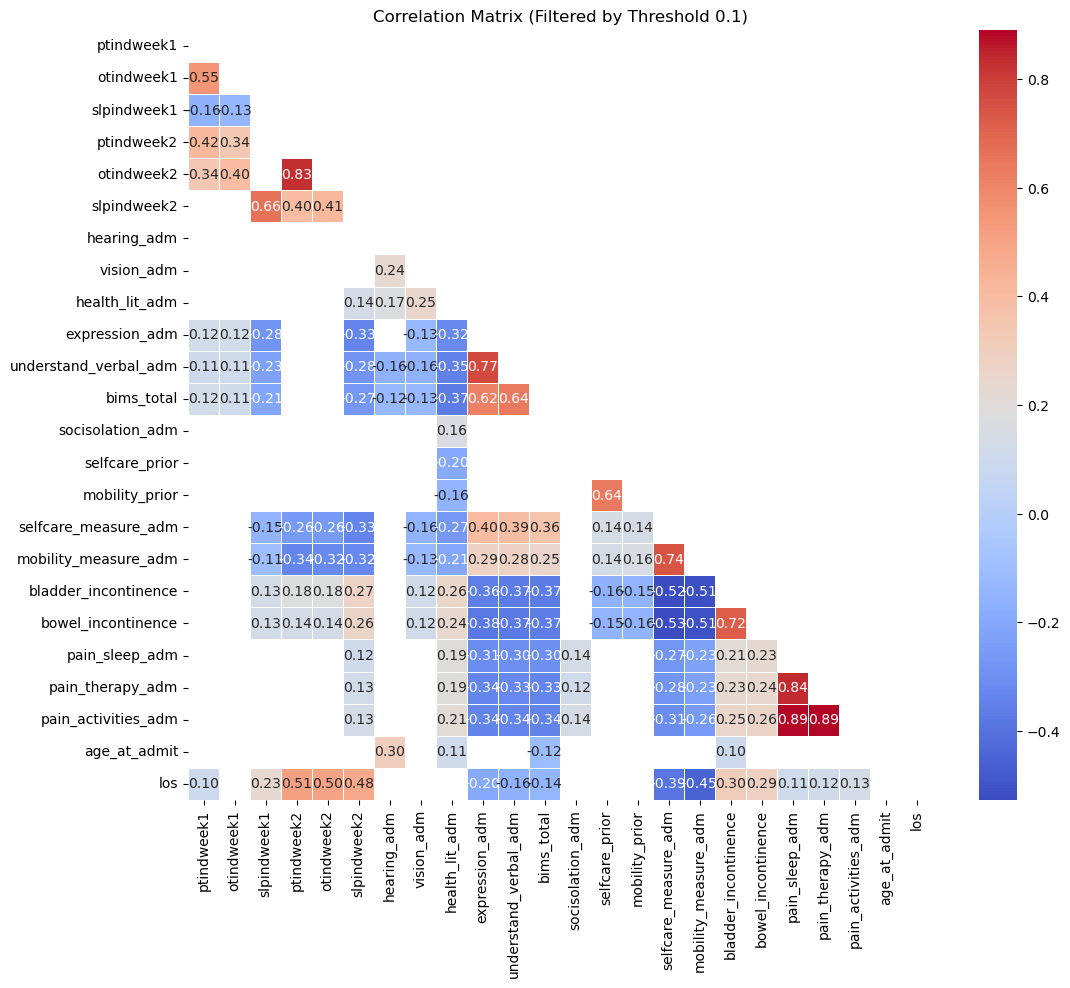

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

TH = 0.1
def generate_correlation_matrix(X, exclude_binary=True, threshold=0.1):
    """
    Generate and visualize the correlation matrix, optionally removing binary variables.

    Parameters:
    - X: DataFrame, predictor variables.
    - exclude_binary: bool, if True, exclude binary variables.
    - threshold: float, filters to show correlations above the threshold (absolute value).

    Returns:
    - corr_matrix: Correlation matrix.
    """
    # Exclude binary variables (columns with only 0 and 1 as unique values)
    if exclude_binary:
        X_filtered = X.loc[:, X.nunique() > 2]
    else:
        X_filtered = X

    # Compute the correlation matrix
    corr_matrix = X_filtered.corr()

    # Filter correlations based on the threshold
    corr_to_plot = corr_matrix.where(np.abs(corr_matrix) > threshold, np.nan)

    # Plot the correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_to_plot, 
        annot=True, 
        cmap="coolwarm", 
        fmt=".2f", 
        linewidths=0.5, 
        mask=np.triu(np.ones_like(corr_to_plot, dtype=bool))  # Mask upper triangle
    )
    plt.title(f"Correlation Matrix (Filtered by Threshold {TH})")
    plt.show()

    return corr_matrix


correlation_matrix = generate_correlation_matrix(X_train, exclude_binary=True, threshold=TH)


In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Initialize Ridge Regressor
ridge_regressor = Ridge(alpha=1.0)  # You can tune alpha as needed

# Fit the model on the train set
ridge_regressor.fit(X_train, y_train)

# Make predictions on all sets
y_train_pred = ridge_regressor.predict(X_train)
y_eval_pred = ridge_regressor.predict(X_eval)
y_test_pred = ridge_regressor.predict(X_test)

# Train set performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Eval set performance
eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

# Test set performance
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge_regressor.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Print performance results
print("---------- Ridge Regression Results ----------")
print("\nPerformance Metrics:")
print(f"Train MSE: {train_mse:.4f}, R²: {train_r2:.4f}")
print(f"Eval  MSE: {eval_mse:.4f}, R²: {eval_r2:.4f}")
print(f"Test  MSE: {test_mse:.4f}, R²: {test_r2:.4f}")

print("\nFeature Coefficients:")
print(coef_df.to_string(index=False))


---------- Ridge Regression Results ----------

Performance Metrics:
Train MSE: 345.0319, R²: 0.2428
Eval  MSE: 337.6636, R²: 0.2549
Test  MSE: 340.1929, R²: 0.2425

Feature Coefficients:
                                       Feature  Coefficient
                          mobility_measure_adm     7.143359
                      low_interest_adm_Unknown     3.437474
                          bladder_incontinence    -3.227440
                         depressed_adm_Unknown    -3.121552
                          selfcare_measure_adm    -3.061816
race_Native_Hawaiian_or_Other_Pacific_Islander    -3.009800
                              race_Multiracial     2.660233
                                    ptindweek1     2.310724
                                    otindweek1     1.849871
                            pressure_ulcer_adm    -1.653221
                                  age_at_admit    -1.542941
                                    bims_total     1.541264
                      marital_st

### 3.2 Mobility

In [14]:

# drop invalid samples & split dataset

mobility_df = df.dropna(subset=["mobility_measure_delta"]).copy()

mobility_split_dict = {} # since some rows are dropped, we need to filter the split dict
for k in split_dict.keys():
    mobility_split_dict[k] = [idx for idx in split_dict[k] if idx in mobility_df.index]

mobility_train_df = mobility_df.loc[mobility_split_dict["train"]]
mobility_eval_df = mobility_df.loc[mobility_split_dict["eval"]]
mobility_test_df = mobility_df.loc[mobility_split_dict["test"]]

if EXCLUDE_THE_OTHER_MEASURE_ADM:
    mobility_predictors = predictors.copy()
    mobility_predictors.remove('selfcare_measure_adm')
else:
    mobility_predictors = predictors

X_train = mobility_train_df[mobility_predictors]
y_train = mobility_train_df['mobility_measure_' + USE_AS_OUTCOME]

X_eval = mobility_eval_df[mobility_predictors]
y_eval = mobility_eval_df['mobility_measure_' + USE_AS_OUTCOME]

X_test = mobility_test_df[mobility_predictors]
y_test = mobility_test_df['mobility_measure_' + USE_AS_OUTCOME]

#### 3.2.1 Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regressor
linear_regressor = LinearRegression()

# Fit the model on the train set
linear_regressor.fit(X_train, y_train)

# Make predictions on all sets
y_train_pred = linear_regressor.predict(X_train)
y_eval_pred = linear_regressor.predict(X_eval)
y_test_pred = linear_regressor.predict(X_test)

# Train set performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Eval set performance
eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

# Test set performance
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")

print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 343.0930893161495
R²: 0.18791862859805286
----------eval set results----------
MSE: 336.02342449974634
R²: 0.20292143144269437
----------test set results----------
MSE: 334.13863237361153
R²: 0.20063692358277418


In [7]:
# linear regression analysis summary

import statsmodels.api as sm

X_train_with_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_with_constant)
results = model.fit()

print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     mobility_measure_delta   R-squared:                       0.188
Model:                                OLS   Adj. R-squared:                  0.187
Method:                     Least Squares   F-statistic:                     140.7
Date:                    Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                            04:45:00   Log-Likelihood:            -1.2417e+05
No. Observations:                   28625   AIC:                         2.484e+05
Df Residuals:                       28577   BIC:                         2.488e+05
Df Model:                              47                                         
Covariance Type:                nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

#### 3.2.2 Random Forest

In [15]:
# RF

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=20)

# fit the model on the train set
rf_regressor.fit(X_train, y_train)

# make predictions on all sets
y_train_pred = rf_regressor.predict(X_train)
y_eval_pred = rf_regressor.predict(X_eval)
y_test_pred = rf_regressor.predict(X_test)

# train set performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# eval set performance
eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

# test set performance
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")


print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 68.4996956708432
R²: 0.8890214186595636
----------eval set results----------
MSE: 304.13542082737365
R²: 0.5116183944272992
----------test set results----------
MSE: 302.0182687706585
R²: 0.5114262499853435


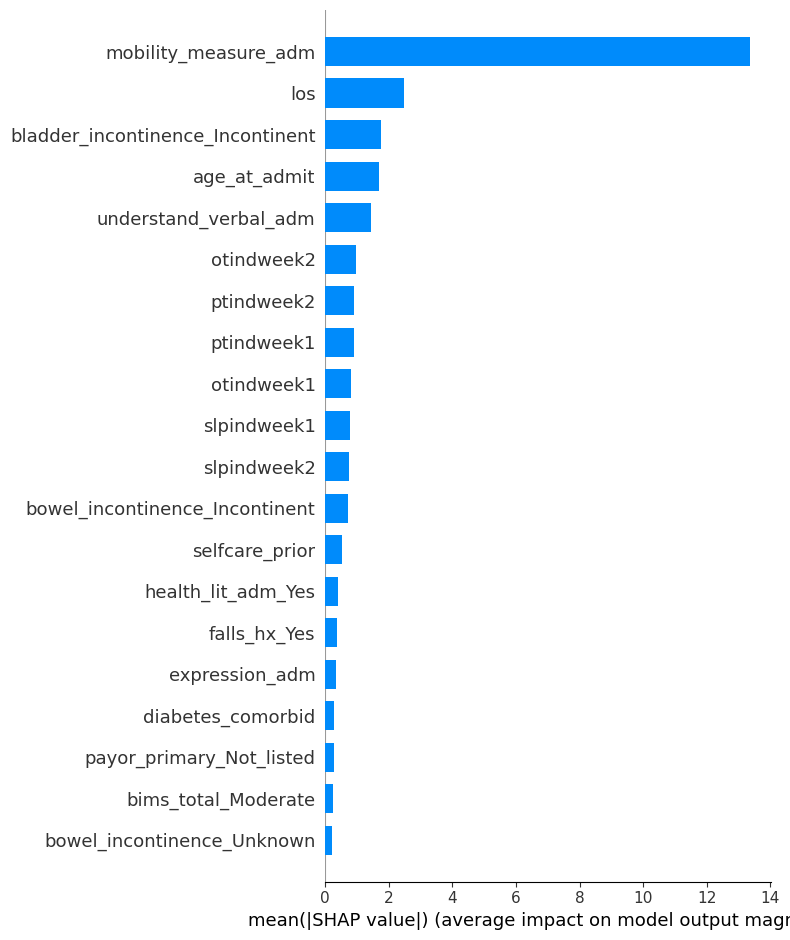

In [16]:
# shapley value test

import shap

explainer = shap.TreeExplainer(rf_regressor)

shap_values_train = explainer.shap_values(X_train, approximate=True) # turn off approximate for precise shap values, but way slower convergence
# shap_values_eval = explainer.shap_values(X_eval)
# shap_values_test = explainer.shap_values(X_test)

shap.summary_plot(shap_values_train, X_train, plot_type="bar")

{'ptindweek1': {'mean': 334.8618938935209, 'std': 98.03107181439556}, 'otindweek1': {'mean': 343.7301457916065, 'std': 93.48791534753497}, 'slpindweek1': {'mean': 206.4069821603242, 'std': 97.2304213018218}, 'ptindweek2': {'mean': 267.2649168568634, 'std': 153.44182705059745}, 'otindweek2': {'mean': 267.13186454888444, 'std': 150.43404230728342}, 'slpindweek2': {'mean': 161.12133774279192, 'std': 125.04271993579322}, 'expression_adm': {'mean': 3.1967255112021986, 'std': 0.9094768485944136}, 'understand_verbal_adm': {'mean': 3.3560249662303785, 'std': 0.8025979421361473}, 'selfcare_prior': {'mean': 2.879104755694257, 'std': 0.3439471858392802}, 'mobility_prior': {'mean': 2.925264334622013, 'std': 0.2868577702334126}, 'selfcare_measure_adm': {'mean': 40.33641785830732, 'std': 7.7260314602189775}, 'mobility_measure_adm': {'mean': 24.16327635194932, 'std': 9.008546930947631}, 'age_at_admit': {'mean': 68.7322418370674, 'std': 13.454395748007565}, 'los': {'mean': 16.196539196050118, 'std': 9

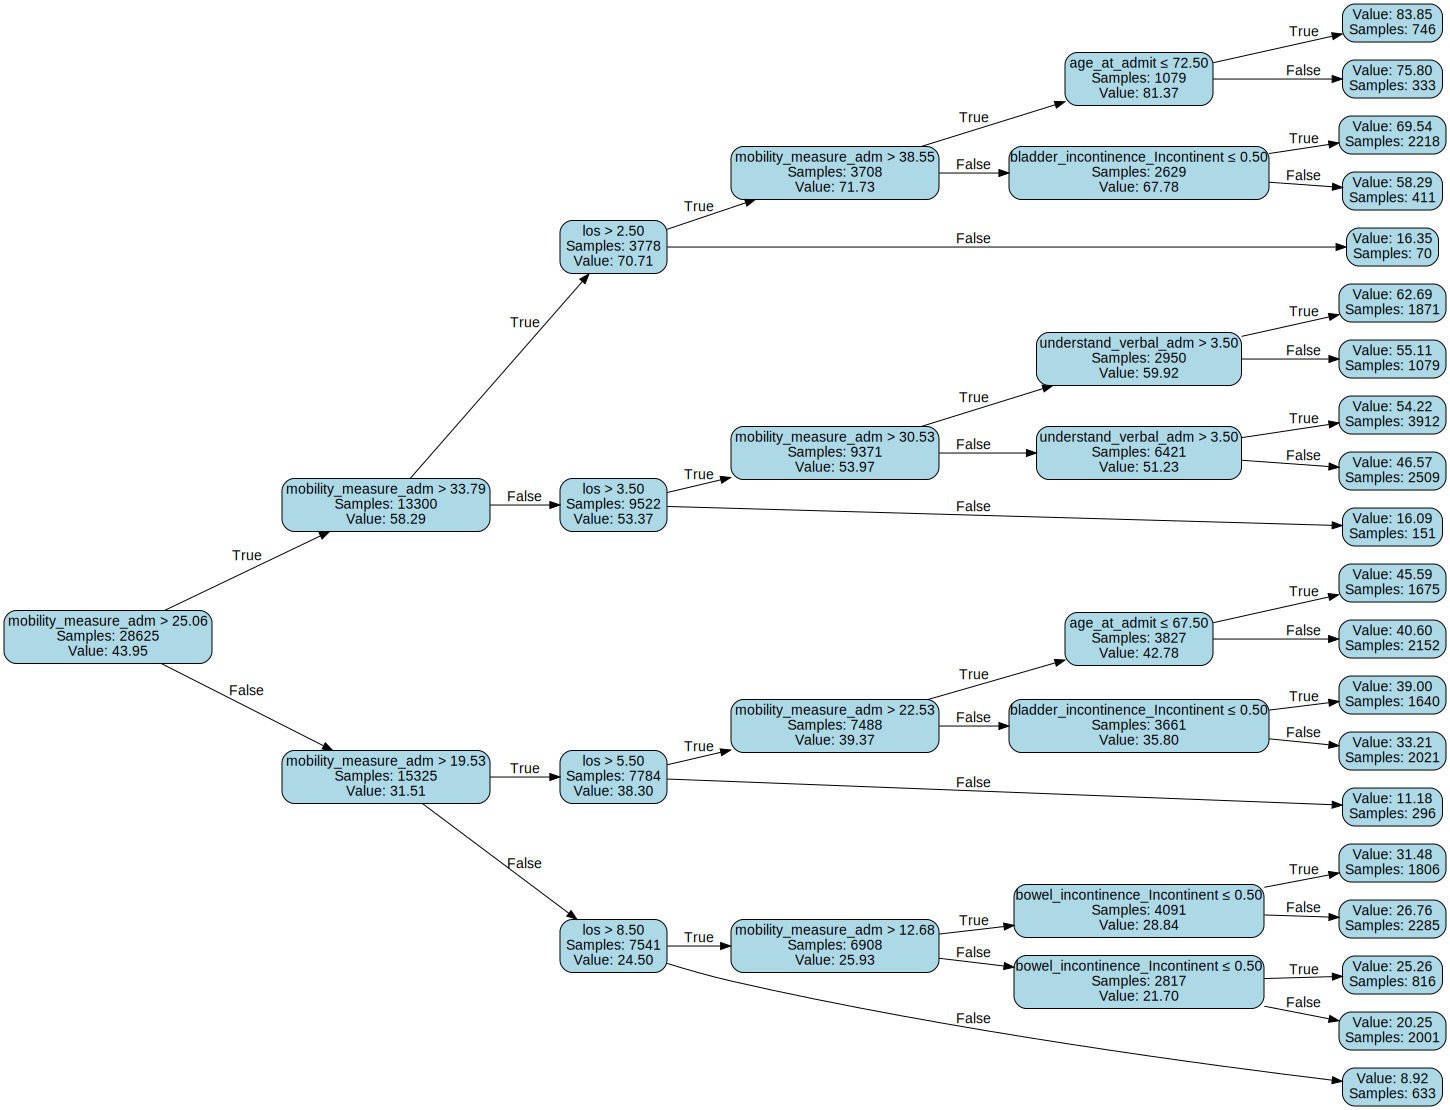

In [18]:
import graphviz
from sklearn.tree import _tree

with open('./data/Cleaned files/standardization_params.json', 'r') as f:
    scaling_params = json.load(f)
print(scaling_params)

def custom_export_graphviz(dtree, feature_names, scaling_params, precision=2, rotate=True, filled=True):
    """
    Final solution: Forces all leaves to the same rank (rightmost column).
    """
    tree_ = dtree.tree_
    total_samples = tree_.n_node_samples[0]
    actual_max_depth = dtree.get_depth()
    threshold_samples = total_samples / (2 ** actual_max_depth)
    
    dot = graphviz.Digraph()
    dot.attr('node', shape='box', style='rounded,filled', fontname='helvetica')
    dot.attr('edge', fontname='helvetica')
    if rotate:
        dot.attr('graph', rankdir='LR')  # Horizontal layout

    leaf_nodes = set()  # Track leaf node IDs

    def get_node_info(node_id):
        if tree_.feature[node_id] == _tree.TREE_UNDEFINED:
            return {
                'is_leaf': True,
                'value': tree_.value[node_id][0][0],
                'samples': tree_.n_node_samples[node_id]
            }
        else:  # Split node
            feature_name = feature_names[tree_.feature[node_id]]
            if feature_name in scaling_params.keys():
                threshold = tree_.threshold[node_id]*scaling_params[feature_name]['std'] + scaling_params[feature_name]['mean']
            else:
                threshold = tree_.threshold[node_id]
            return {
                'is_leaf': False,
                'feature': feature_name,
                'threshold': threshold,
                'samples': tree_.n_node_samples[node_id],
                'value': tree_.value[node_id][0][0],
                'left_child': tree_.children_left[node_id],
                'right_child': tree_.children_right[node_id]
            }

    def add_node(node_id, parent=None, edge_label=None, current_depth=0):
        info = get_node_info(node_id)
        node_name = str(node_id)
        
        # Early stopping if sample size is below threshold
        if not info['is_leaf'] and info['samples'] < threshold_samples:
            info['is_leaf'] = True

        if info['is_leaf']:
            label = f"Value: {info['value']:.{precision}f}\nSamples: {info['samples']}"
            leaf_nodes.add(node_name)  # Track leaf node
        else:
            # Determine true/false branches based on mean values
            left_val = get_node_info(info['left_child'])['value']
            right_val = get_node_info(info['right_child'])['value']
            
            # Flip condition to ensure True branch has higher value
            if left_val < right_val:
                condition = f"{info['feature']} > {info['threshold']:.{precision}f}"
                true_child = info['right_child']
                false_child = info['left_child']
            else:
                condition = f"{info['feature']} ≤ {info['threshold']:.{precision}f}"
                true_child = info['left_child']
                false_child = info['right_child']
            
            label = f"{condition}\nSamples: {info['samples']}\nValue: {info['value']:.{precision}f}"

            # Assign true_child and false_child to info for recursion
            info['true_child'] = true_child
            info['false_child'] = false_child

        # Add node to graph
        dot.node(node_name, label=label, fillcolor='lightblue' if filled else None)
        
        if parent is not None:
            dot.edge(parent, node_name, label=edge_label)
        
        # Recurse if not leaf
        if not info['is_leaf']:
            add_node(info['true_child'], node_name, 'True', current_depth + 1)
            add_node(info['false_child'], node_name, 'False', current_depth + 1)

    add_node(0, current_depth=0)

    # Force all leaves to the same rank
    with dot.subgraph() as s:
        s.attr(rank='same')  # Align all nodes in this subgraph to the same rank
        for leaf in leaf_nodes:
            s.node(leaf)

    return dot

# regress a summary tree and visualize

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# initialize the decision tree regressor
tree_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)  # you can adjust max_depth

# train a single regression tree to previous model's output
tree_regressor.fit(X_train, y_train_pred)

# test model
y_test_pred_pred = tree_regressor.predict(X_test)
print(f"min y_test = {min(y_test)}")
test_pred_mse = mean_squared_error(y_test_pred, y_test_pred_pred) # with previous model's output
test_pred_r2 = r2_score(y_test_pred, y_test_pred_pred)
test_mse = mean_squared_error(y_test, y_test_pred_pred) # with GT
test_r2 = r2_score(y_test, y_test_pred_pred)
print(f'MSE (w.r. previous model): {test_pred_mse}')
print(f"R² (w.r. previous model): {test_pred_r2}")
print(f'MSE (w.r. ground truth): {test_mse}')
print(f"R² (w.r. ground truth): {test_r2}")

# Generate visualization
dot = custom_export_graphviz(
    tree_regressor, 
    feature_names=mobility_predictors,
    scaling_params=scaling_params,
    precision=2,
    rotate=True,
    filled=True
)

# Render and display
dot.render(filename='mobility_tree', format='png', cleanup=True)
display(dot)  # For Jupyter notebooks

#### 3.2.3 XGBoost

In [11]:
# xgboost

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb_regressor = XGBRegressor(n_estimators=100, max_depth=6, random_state=42)

xgb_regressor.fit(X_train, y_train)

y_train_pred = xgb_regressor.predict(X_train)
y_eval_pred = xgb_regressor.predict(X_eval)
y_test_pred = xgb_regressor.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")


print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 180.21888439574275
R²: 0.5734323909457569
----------eval set results----------
MSE: 300.30085734442275
R²: 0.2876586569374576
----------test set results----------
MSE: 302.6711353841106
R²: 0.2759169204571008


In [12]:
from tabulate import tabulate

booster = xgb_regressor.get_booster()
importance_dict = booster.get_score(importance_type='gain')

importance_list = [(feature, score) for feature, score in importance_dict.items()]

importance_list = sorted(importance_list, key=lambda x: x[1], reverse=True)

print(tabulate(importance_list, headers=["Feature", "Gain"], tablefmt="pretty"))

+------------------------------------------------+--------------------+
|                    Feature                     |        Gain        |
+------------------------------------------------+--------------------+
|              bladder_incontinence              |    8338.0546875    |
|                      los                       |  8174.39404296875  |
|              selfcare_measure_adm              |  7666.26708984375  |
|                 mobility_prior                 |  5612.55517578125  |
|                 selfcare_prior                 |  4963.05419921875  |
|              mobility_measure_adm              | 3342.618896484375  |
|             understand_verbal_adm              | 3233.240478515625  |
|               bowel_incontinence               |     3011.65625     |
|                  falls_hx_Yes                  |  2964.8857421875   |
|             depressed_adm_Unknown              | 2394.413818359375  |
|            payor_primary_Not_listed            | 2313.27368164

#### 3.2.4 Lasso

In [50]:
# lasso with manually tuned hyperparam alpha
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

lasso_regressor = Lasso(alpha=0.01, max_iter=10000, random_state=42)

lasso_regressor.fit(X_train, y_train)

y_train_pred = lasso_regressor.predict(X_train)
y_eval_pred = lasso_regressor.predict(X_eval)
y_test_pred = lasso_regressor.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

# model summary
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_regressor.coef_
})

# filter out features with zero coefficients
non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

print("\n---------- Model Summary: Non-zero Coefficients ----------")
print(tabulate(non_zero_coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True), headers='keys'))


---------- Train Set Results ----------
MSE: 343.1568
R²: 0.1878
---------- Eval Set Results ----------
MSE: 335.8325
R²: 0.2034
---------- Test Set Results ----------
MSE: 334.0015
R²: 0.2010

---------- Model Summary: Non-zero Coefficients ----------
    Feature                           Coefficient
--  ------------------------------  -------------
 0  ptindweek1                         2.37798
 1  selfcare_measure_adm               2.07926
 2  mobility_measure_adm               1.96905
 3  payor_primary_Not_listed           1.68515
 4  otindweek1                         1.48449
 5  slpindweek1                        1.25747
 6  race_White                         0.998599
 7  selfcare_prior                     0.906513
 8  payor_primary_Medicare_FFS         0.852444
 9  bims_total                         0.852094
10  hispanic_Yes                       0.845753
11  marital_status_Unmarried           0.833826
12  pain_activities_adm                0.792425
13  understand_verbal_adm    

In [51]:
# lasso with cross validation for tuning alpha
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

alpha_range = [0.001, 0.05, 0.03, 0.01, 0.5, 0.1, 0.5, 1, 5, 10, 50, 100]

lasso_cv = LassoCV(alphas=alpha_range, cv=5, max_iter=10000, random_state=42)

lasso_cv.fit(X_train, y_train)

best_alpha = lasso_cv.alpha_
print(f"Best alpha found: {best_alpha}")

y_train_pred = lasso_cv.predict(X_train)
y_eval_pred = lasso_cv.predict(X_eval)
y_test_pred = lasso_cv.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_cv.coef_
})

non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

print("\n---------- Model Summary: Non-zero Coefficients ----------")
print(non_zero_coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True))


Best alpha found: 0.01
---------- Train Set Results ----------
MSE: 343.1568
R²: 0.1878
---------- Eval Set Results ----------
MSE: 335.8325
R²: 0.2034
---------- Test Set Results ----------
MSE: 334.0015
R²: 0.2010

---------- Model Summary: Non-zero Coefficients ----------
                           Feature  Coefficient
0                       ptindweek1     2.377984
1             selfcare_measure_adm     2.079261
2             mobility_measure_adm     1.969053
3         payor_primary_Not_listed     1.685146
4                       otindweek1     1.484493
5                      slpindweek1     1.257467
6                       race_White     0.998599
7                   selfcare_prior     0.906513
8       payor_primary_Medicare_FFS     0.852444
9                       bims_total     0.852094
10                    hispanic_Yes     0.845753
11        marital_status_Unmarried     0.833826
12             pain_activities_adm     0.792425
13           understand_verbal_adm     0.780746
14  

In [52]:
# 1SE rule

# Cross-validation MSE path and SE calculation
mean_cv_errors = np.mean(lasso_cv.mse_path_, axis=1)
std_cv_errors = np.std(lasso_cv.mse_path_, axis=1) / np.sqrt(lasso_cv.mse_path_.shape[1])
min_error = mean_cv_errors.min()
min_error_se = std_cv_errors[mean_cv_errors.argmin()]

# 1SE Rule: Select the largest alpha within 1SE of the minimum error
alphas_within_1se = [
    alpha for alpha, mean_error in zip(lasso_cv.alphas_, mean_cv_errors)
    if mean_error <= min_error + min_error_se
]
alpha_1se = max(alphas_within_1se)  # Largest alpha within 1SE

# Print results
print(f"Best alpha (min error): {best_alpha}")
print(f"Alpha selected by 1SE rule: {alpha_1se}")

# Fit Lasso with alpha from 1SE rule
lasso_1se = LassoCV(alphas=[alpha_1se], cv=5, max_iter=10000, random_state=42)
lasso_1se.fit(X_train, y_train)

# Predict and evaluate
y_train_pred = lasso_1se.predict(X_train)
y_eval_pred = lasso_1se.predict(X_eval)
y_test_pred = lasso_1se.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("\n---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("\n---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

# Non-zero coefficients summary
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_1se.coef_
})

non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

print("\n---------- Model Summary: Non-zero Coefficients ----------")
print(non_zero_coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True))


Best alpha (min error): 0.01
Alpha selected by 1SE rule: 0.1

---------- Train Set Results ----------
MSE: 344.2645
R²: 0.1851

---------- Eval Set Results ----------
MSE: 336.2865
R²: 0.2023

---------- Test Set Results ----------
MSE: 334.4508
R²: 0.1999

---------- Model Summary: Non-zero Coefficients ----------
                           Feature  Coefficient
0                       ptindweek1     2.238204
1             selfcare_measure_adm     2.041735
2             mobility_measure_adm     1.960027
3                       otindweek1     1.356835
4                      slpindweek1     1.273856
5                   selfcare_prior     0.906201
6         payor_primary_Not_listed     0.850155
7                       bims_total     0.767928
8                   mobility_prior     0.682834
9            understand_verbal_adm     0.626199
10                      race_White     0.605145
11        marital_status_Unmarried     0.351502
12                             los     0.221773
13         

#### 3.2.5 Forward Selection

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import make_scorer, mean_squared_error
import pandas as pd

# ensure therapy predictors are included first
therapy_predictors = list(therapy_predictors)
remaining_features = [feature for feature in X_train.columns if feature not in therapy_predictors]

linear_model = LinearRegression()

# scoring func
scorer = make_scorer(mean_squared_error, greater_is_better=False)

sfs = SequentialFeatureSelector(
    linear_model,
    n_features_to_select="auto",  # specify an exact number of features if needed
    direction="forward",
    scoring=scorer,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1
)

sfs.fit(X_train[remaining_features], y_train)

selected_features = therapy_predictors + list(sfs.get_feature_names_out(remaining_features))

print("Selected features:", selected_features)

linear_model.fit(X_train[selected_features], y_train)

y_train_pred = linear_model.predict(X_train[selected_features])
y_eval_pred = linear_model.predict(X_eval[selected_features])
y_test_pred = linear_model.predict(X_test[selected_features])

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")


KeyboardInterrupt: 

In [ ]:
# linear regression analysis summary

import statsmodels.api as sm

X_train_with_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_with_constant)
results = model.fit()

print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     selfcare_measure_delta   R-squared:                       0.310
Model:                                OLS   Adj. R-squared:                  0.306
Method:                     Least Squares   F-statistic:                     97.52
Date:                    Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                            04:56:44   Log-Likelihood:            -1.2293e+05
No. Observations:                   28625   AIC:                         2.461e+05
Df Residuals:                       28493   BIC:                         2.472e+05
Df Model:                             131                                         
Covariance Type:                nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

#### 3.2.6 Interaction terms between therapy amounts and other variables

In [67]:
GROUP_THERAPY_BY_WEEK = True

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


def add_interaction_terms(X):
    """
    Adds interaction terms between columns in therapy_predictors and all other columns.
    """
    X = X.copy()
    interaction_dict = {}

    if GROUP_THERAPY_BY_WEEK:
        X = X.copy()
        # Group therapy predictors by week
        X["sumindweek1"] = (
            X["ptindweek1"] + X["otindweek1"] + X["slpindweek1"]
        )
        X["sumindweek2"] = (
            X["ptindweek2"] + X["otindweek2"] + X["slpindweek2"]
        )
        X = X.drop(
            columns=["ptindweek1", "otindweek1", "slpindweek1", 
                     "ptindweek2", "otindweek2", "slpindweek2"]
        )
        # Define new therapy predictor
        therapy_predictors_interaction_only = ["sumindweek1", "sumindweek2"]
    else:
        therapy_predictors_interaction_only = therapy_predictors
    
    # Loop through therapy predictors and create interaction terms
    for therapy_col in therapy_predictors_interaction_only:
        if therapy_col in X.columns:
            for col in X.columns:
                # Skip interaction with itself or other therapy predictors
                if col != therapy_col and col not in therapy_predictors:
                    # Generate the interaction term name
                    interaction_term = f"{therapy_col}_x_{col}"
                    # Calculate the interaction and add to the dictionary
                    interaction_dict[interaction_term] = X[therapy_col] * X[col]
                    
    # Convert the interaction terms dictionary to a DataFrame
    interaction_df = pd.DataFrame(interaction_dict)
    
    # Concatenate the original DataFrame with the interaction terms DataFrame
    X_interactions = pd.concat([X, interaction_df], axis=1)
    
    return X_interactions


X_train_interactions = add_interaction_terms(X_train)
X_eval_interactions = add_interaction_terms(X_eval)
X_test_interactions = add_interaction_terms(X_test)

# Initialize the Linear Regressor
linear_regressor = LinearRegression()

# Fit the model on the train set
linear_regressor.fit(X_train_interactions, y_train)

# Make predictions on all sets
y_train_pred = linear_regressor.predict(X_train_interactions)
y_eval_pred = linear_regressor.predict(X_eval_interactions)
y_test_pred = linear_regressor.predict(X_test_interactions)

# Train set performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Eval set performance
eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

# Test set performance
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print("----------train set results----------")
print(f"MSE: {train_mse}")
print(f"R²: {train_r2}")

print("----------eval set results----------")
print(f"MSE: {eval_mse}")
print(f"R²: {eval_r2}")

print("----------test set results----------")
print(f"MSE: {test_mse}")
print(f"R²: {test_r2}")


----------train set results----------
MSE: 323.7196036941176
R²: 0.23377454135961306
----------eval set results----------
MSE: 323.0926686870763
R²: 0.2335943773805299
----------test set results----------
MSE: 316.9401686894573
R²: 0.24178097430972967


In [17]:
# linear regression analysis summary

import statsmodels.api as sm

X_train_with_constant = sm.add_constant(X_train_interactions)

model = sm.OLS(y_train, X_train_with_constant)
results = model.fit()

print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     mobility_measure_delta   R-squared:                       0.237
Model:                                OLS   Adj. R-squared:                  0.230
Method:                     Least Squares   F-statistic:                     30.11
Date:                    Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                            04:47:03   Log-Likelihood:            -1.2327e+05
No. Observations:                   28625   AIC:                         2.471e+05
Df Residuals:                       28331   BIC:                         2.496e+05
Df Model:                             293                                         
Covariance Type:                nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [68]:
# lasso with cross validation for tuning alpha
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

alpha_range = [0.001, 0.05, 0.03, 0.01, 0.5, 0.1, 0.5, 1, 5, 10, 50, 100]

lasso_cv = LassoCV(alphas=alpha_range, cv=5, max_iter=100000, random_state=42)

lasso_cv.fit(X_train_interactions, y_train)

best_alpha = lasso_cv.alpha_
print(f"Best alpha found: {best_alpha}")

y_train_pred = lasso_cv.predict(X_train_interactions)
y_eval_pred = lasso_cv.predict(X_eval_interactions)
y_test_pred = lasso_cv.predict(X_test_interactions)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

coef_df = pd.DataFrame({
    'Feature': X_train_interactions.columns,
    'Coefficient': lasso_cv.coef_
})

non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

print("\n---------- Model Summary: Non-zero Coefficients ----------")
print(non_zero_coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True))


Best alpha found: 0.03
---------- Train Set Results ----------
MSE: 323.9644
R²: 0.2332
---------- Eval Set Results ----------
MSE: 321.8627
R²: 0.2365
---------- Test Set Results ----------
MSE: 315.8234
R²: 0.2445

---------- Model Summary: Non-zero Coefficients ----------
                     Feature  Coefficient
0       selfcare_measure_adm     1.953066
1       mobility_measure_adm     1.486779
2   payor_primary_Not_listed     1.215819
3             selfcare_prior     0.932671
4                 bims_total     0.932053
..                       ...          ...
87              pvd_comorbid    -1.035529
88              age_at_admit    -1.440031
89        pressure_ulcer_adm    -1.663667
90              falls_hx_Yes    -1.714080
91      bladder_incontinence    -2.640863

[92 rows x 2 columns]


In [69]:
# 1SE rule

# Cross-validation MSE path and SE calculation
mean_cv_errors = np.mean(lasso_cv.mse_path_, axis=1)
std_cv_errors = np.std(lasso_cv.mse_path_, axis=1) / np.sqrt(lasso_cv.mse_path_.shape[1])
min_error = mean_cv_errors.min()
min_error_se = std_cv_errors[mean_cv_errors.argmin()]

# 1SE Rule: Select the largest alpha within 1SE of the minimum error
alphas_within_1se = [
    alpha for alpha, mean_error in zip(lasso_cv.alphas_, mean_cv_errors)
    if mean_error <= min_error + min_error_se
]
alpha_1se = max(alphas_within_1se)  # Largest alpha within 1SE

# Print results
print(f"Best alpha (min error): {best_alpha}")
print(f"Alpha selected by 1SE rule: {alpha_1se}")

# Fit Lasso with alpha from 1SE rule
lasso_1se = LassoCV(alphas=[alpha_1se], cv=5, max_iter=10000, random_state=42)
lasso_1se.fit(X_train_interactions, y_train)

# Predict and evaluate
y_train_pred = lasso_1se.predict(X_train_interactions)
y_eval_pred = lasso_1se.predict(X_eval_interactions)
y_test_pred = lasso_1se.predict(X_test_interactions)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

eval_mse = mean_squared_error(y_eval, y_eval_pred)
eval_r2 = r2_score(y_eval, y_eval_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n---------- Train Set Results ----------")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("\n---------- Eval Set Results ----------")
print(f"MSE: {eval_mse:.4f}")
print(f"R²: {eval_r2:.4f}")

print("\n---------- Test Set Results ----------")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

# Non-zero coefficients summary
coef_df = pd.DataFrame({
    'Feature': X_train_interactions.columns,
    'Coefficient': lasso_1se.coef_
})

non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

print("\n---------- Model Summary: Non-zero Coefficients ----------")
print(non_zero_coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True))


Best alpha (min error): 0.03
Alpha selected by 1SE rule: 0.1

---------- Train Set Results ----------
MSE: 325.2945
R²: 0.2300

---------- Eval Set Results ----------
MSE: 321.9947
R²: 0.2362

---------- Test Set Results ----------
MSE: 316.1936
R²: 0.2436

---------- Model Summary: Non-zero Coefficients ----------
                                     Feature  Coefficient
0                       selfcare_measure_adm     1.882533
1                       mobility_measure_adm     1.461744
2                             selfcare_prior     0.933889
3                                 bims_total     0.868202
4         sumindweek1_x_mobility_measure_adm     0.770175
5                             mobility_prior     0.768207
6                   payor_primary_Not_listed     0.676640
7                      understand_verbal_adm     0.664408
8                                sumindweek1     0.632398
9         sumindweek2_x_bladder_incontinence     0.393663
10         sumindweek2_x_acute_mental_change 